In [2]:
import numpy as np
import stressfit.shapes as S
import stressfit.sample as sam
import stressfit.graphs as gr
import stressfit.mccfit as mc
from IPython.display import HTML
deg = np.pi/180.
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>To hide/show the code blocks, click <a href="javascript:code_toggle()">here</a>.</b>''')

# STRESSFIT
<p>
<i>Written by:</i> Jan Saroun, Nuclear Physics Institute CAS, Rez, saroun@ujf.cas.cz<br/>
<i>Date:</i> 22/05/2018<br/>
<i>Version:</i> 0.9.2<br/>
<i>Source:</i> https://github.com/NPLtools/stressfit
</p>
<p>
This script permits to treat pseudo strains in neutron residual strain measurements. Pseudo strains due to partial immersion of sampling volume in the sample, steep intrinsic strain gradients and heterogeneous distribution of scattering probability can be treated. The script employs Monte Carlo convolution method, which uses sampling points produced by Monte Carlo ray-tracing simulation of the diffractometer to model smearing of intrinsic sample properties by instrumental response. Each point has all available information about a scattering event: position, initial and final neutron wave vector, probability and dhkl value associated with this sampling point. Such a sampling distribution can be simulated rather quickly for any instrument setup, for example by the ray-tracing program SIMRES (http://neutron.ujf.cas.cz/restrax). The sampling distribution is then reused to cary out the convolution with any sample shape, position, orientation and strain distribution. This decoupling of MC ray-tracing simulation from the convolution procedure permits to write a code which is rather fast (typically about 1s per one scan at 1 CPU). It is therefore possible to use the MC integration as a part of cost function for least squares fitting.
</p><p>
Development of a Python library STRESSFIT aims at providing tools for analysis of residual stress measurements, where pseudo strains can't be avoided and must be taken into account in data processing. Currently, STRESSFIT enables to model pseudo strains for several basic sample shapes (curved plates, full and hollow cylinders and spheres). It also enables least squares fitting of measured scans for a single strain component. Simultaneous fitting of multiple components with a single stress distribution model is envisaged in future versions. 
</p>

## Jupyter viewer
Examples with output of STRESSFIT are also available via Jupyter viewer server:
<p>
<a href='http://nbviewer.jupyter.org/url/neutron.ujf.cas.cz/restrax/download/stressfit/stressfit_example1.ipynb'>
Example 1</a>: ECNS2019, Fitting of strain gradient under the inner surface of a tube, test on synthetic data for STRESS-SPEC.
</p>

## Documentation
<p>
For more information, see: <br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/saroun_MECASENS_2017.pdf'>MECASENS 2017 poster</a><br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/ECRS2018_stressfit.pdf'>ECRS10, 2018, slides</a><br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/saroun_ECNS2019_poster.pdf'>ECNS 2019, poster</a> <br/>
</p>


In [3]:
# Define environment
# input data folder
inpath = mc.path2win(r'.\input')
# output data folder
outpath = mc.path2win(r'.\output')

## Sample definition
Following block defines the <b>sample shape, position and orientation.</b>
### Coordinates
The laboratory frame is defined by y-axis vertical and z-axis pointing along the incident beam.
The positioning includes rotation by YXY Euler angles ($\omega$, $\chi$, $\phi$) and a linear shift (multiple commands <code>rotate</code> and <code>moveTo</code> are possible to achieve required position).

Imported MC events are defined in the laboratory frame, with the origin at the centre of the instrumental gauge volume. Sample position and orientation thus define zero scan position and scan direction in the sample.

### Sample shape
Sample dimensions depend on the selected shape. Choose one of the classes defined in the Shapes folder of the package:

<code> S.ShapePlate(thickness) </code> <br />
An infinitely large flat plate of given thickness.

<code> S.ShapePlateCurved(thickness, length, height, [r1x, r1y],  [r2x, r2y]) </code><br />
A curved plate of given thickness (z), length (x) and height (y). <code>[r1x, r1y]</code> are curvature radii along x and y of the front surcae (z>0). <code>[r2x, r2y]</code> are the radii for the rear surface.

<code> S.ShapeCyl(radius, height) </code><br />
A cylindrical shape with axis along y-axis.

<code> S.ShapeShellCyl(Rin, Rout, height) </code><br /> 
A hollow cylinder with axis along y-axis. Rin, Rout are the inner and outer radii.

<code> S.ShapeSph(radius) </code> <br />
A spherical sample.

The next block in this template defines a tube: a hollow cylinder with inner radius 4 mm, outer radius 8 mm and height 50 mm. Zero scan position corresponds to the instrumental gauge volume centered at the surface. Measured strain direction is defined by the angle <code>omega</code>.


In [4]:
# 1. Sample orientation:

# Sample rotation. 
# At zero angles, the z-axis is parallel to the beam, y-axis is vertical.
# omega, chi, phi are Euler angles (rotation around Y, X, Y).
# Example for a plate symmetric reflection with incidence angle = theta:
#   set chi=0, phi=0, omega=90 + theta

omega = 180*deg + 45*deg
chi = 0.0*deg
phi = 0.0*deg

# Scattering angle
take_off = 91.77*deg 

# Set sample shape (see comment above).
# Dimensions [mm]
radius1 = 4.
radius2 = 8
height = 50.0
shape = S.ShapeShellCyl(radius1, radius2, height)

# Set sample position
shape.rotate(omega, chi, phi)
shape.moveTo(np.array([0., 0., 0]))

# Assign shape
sam.shape = shape

# Define beam attenuation coefficient. Uncomment one of the two options: 
# Option 1: Set attenuation as a table (wavelength, mu), [1/cm]. The file must be in the input directory.
exttab = np.loadtxt('tables/Fe_mu.dat')
sam.setExtinction(table=exttab)  # lookup table

# Option 2: Set attenuation as a single coefficient [1/cm]:
# sam.setExtinction(mu=1.96) # single value

# define ki and kf vectors in laboratory frame
ki = np.array([0., 0., 1.])  # default for SIMRES simulations
kf = sam.rotate(ki, 1, take_off) # rotation of ki by the take-off angle

## Sampling distribution
Load Monte Carlo events representing the sampling distribution from a text file.
The event table contains neutron coordinates, weights and dhkl values.  You need to specify column numbers for position, ki and kf vectors, weights and dhkl.

Imported MC events are defined in the laboratory frame, with the origin at the centre of the instrumental gauge volume. Sample and orientation thus defines zero scan position and scan direction in the sample.

In [5]:
# load sampling points
gpath = r'./input/'
data = np.loadtxt(gpath + "events_S_1mm.dat")
columns = [1, 4, 7, 10, 11]  # index of r[0], ki[0], kf[0], weight and dhkl (column indexing starts from 0)
nrec = data.shape[0]

# Set the events to the sample component
sam.setSamplingEvents(data, columns)

# Calculate centre of mass of the distribution 
P = data[:,columns[3]]/np.sum(data[:,columns[3]])
ctr = np.zeros(3)
for i in range(3):
	ctr[i] = data[:, columns[0] + i].dot(P)
dmean = data[:, columns[4]].dot(P)
print('Loaded event list with {:d} records'.format(nrec))    
print('Gauge centre: [{:g}, {:g}, {:g}] '.format(*ctr))
print('d0 = {:g}\n'.format(dmean))

# Set the events to the sample component
sam.setSamplingEvents(data, columns, ctr=ctr)

Loaded event list with 40000 records
Gauge centre: [-0.00290722, -0.0084368, -0.0622329] 
d0 = 1.16986



## Scan definition
Define scan steps, direction and calculate corresponding depth scale. At the end, the diffraction geometry is plotted together with the sampling points. <b>The red arrow shows the direction of sample motion.</b>  Color scale of the sampling points shows the associated pseudo-strains.

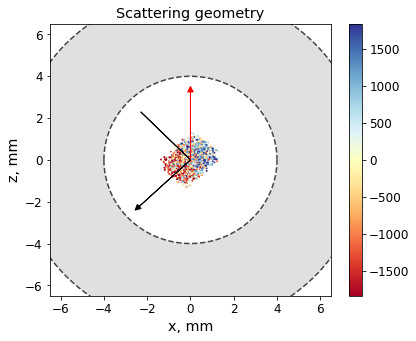

In [6]:
# Scan direction (local coordinates)
sdir = [0., 0., -1.]
# number of sampling events to use for convolution
nev = 2000    

# plot the situation
nd = nev  # number of events to show
rang = [13, 13]  # plot range in [mm]
proj = 1  # projection plane (zy=0, xz=1, xy=2)
outpng = outpath + 'scene.png'
gr.plotScene(rang, proj, shape, ki, kf, sdir, sam.getSampling(nev) , save = True, file = outpng)

## Input data
Load integral peak intensities and strains measured as a function of scan depth in two separate arrays with three columns: depth [mm], intensity [any unit] or strain [$\mu\epsilon = 10^{-6}$] and error (std. deviation).

In [7]:
# intensities, file name
intfile = 'int_SS_hoop.dat'

# intensities, file name
epsfile = 'eps_SS_hoop.dat'

# load data
intdata = np.loadtxt(inpath + intfile)
epsdata = np.loadtxt(inpath + epsfile)

## Fit intensities
Fitting of intensities allows to determine the variation of scattering probability and extinction with scan depth. It can also help to correct for any missfit between the encoder positions (stored in the data file) and true surface position. Note that sometimes these effects can't be distinguished from each other. With a strong variation of scattering probability (e.g. due to a greadient in texture or composition near the surface), it is not possible to reliably determine the surface position and extinction just from the intensity variation. Then some of the parameters must be determined independently and fixed for fitting. On the other hand, it is the product of extinction and scattering probability distributions which affects pseudo-strains, therefore they do not need to be exactly distinguished.

NOTE:<br/>
Scattering probability and strain distributions are defined on depth scale, where depth is the shortest distance to the front sample surface. Definition of the <i>front surface</i> depends on the sample shape. For plates, it is the distance to the upper surface (in local coordinates of the sample). For sphers and cylinders, it is the distance from the curved surface (the outer one in the case of hollow shapes).

### Define initial values

The depth distributions are modelled as a set of points interpolated by splines of selected order (1 to 3). Define below a minimum number of depth and intensity values which gives a satisfactory estimate of the intensity variation. Obviously, the intensity values should be kept constant for homogeneous materials.

runFit finished



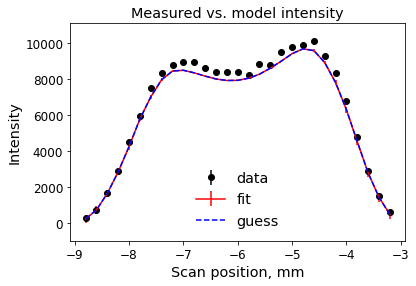

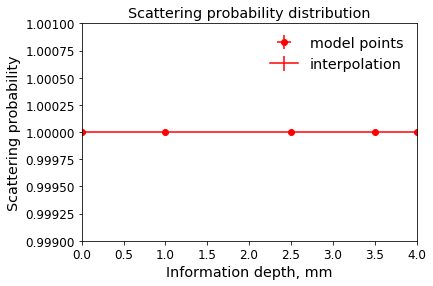

In [8]:
# MODEL PARAMETERS
# Give initial values, followed by flags (0|1), fx=1 means a free variable, 0 for fixed. 

# depth values [mm]
x =  [0., 1., 2.5, 3.5, 4]
fx = [0, 0, 0, 0, 0]

# intrinsic scattering intensity [rel. units]
y = [1., 1.0, 1.0, 1., 1.]
fy = [0, 0, 0, 0, 0]

# Set the method for interpolation between the nodes.
# Use one of 'natural','clamped', 'PCHIP', 'Akima'
interpolation = 'PCHIP' # PCHIP = Piecewise cubic Hermitian interpolation polynomial

# Background and amplitude
A = 33000
B = 0
# fixed (0) or free (1):
fA = 1
fB = 0

# zero encoder position = position of the front surface in encoder scale
# = where is the surcae position in the data table ...
zc = 0.05
# fixed (0) or free (1):
fzc = 1

#--------------------------------------------
# Initialize model
# nev = number of neutrons to use
# xdir = the scan direction (defined above)
ifit = mc.Ifit(nev=2000, xdir = sdir, ftol=1.e-3, epsfcn=0.1)

# assign exp. data to the model
ifit.data = intdata

# define the intensity distribution, dim=number of points for interpolation 
ifit.defDistribution([x, y], [fx, fy], ndim=200)
# define scaling (background, amplitude and depth shift). minval,maxval=limits of these parameters.
ifit.defScaling([A, B, zc], [fA, fB, fzc], minval=[0., 0., -np.inf])
# set the interpolation method
ifit.setInterpModel(interpolation)

# Guess fit (optional)
# It makes a fast first estimate.  
# Set maxiter=0 if you don't want to fit, just plot the initial model.
mc.runFit(ifit, maxiter=0, guess=True)

# show plots
# Add file=name parameter if you want to save the result.
ifit.reportFit()

### Run fit
Is the above estimate good? Then execute the following box to run fitting procedure and plot results.

In [9]:
# Use bootstrap method for estimation of confidence limits?
bootstrap = False
# Set loops for the number of bootstrap cycles.
loops = 3
# regularization
areg = 1e-3
# Set True to run intensity fit
runIFit = True

if runIFit:
    res = mc.runFit(ifit, maxiter=100, areg=areg, bootstrap=bootstrap, loops=loops)

iter=1, chi2=257.395, reg=257.395
iter=6, chi2=28.5878, reg=28.5878
iter=9, chi2=17.2181, reg=17.2181
iter=12, chi2=16.0313, reg=16.0313
iter=15, chi2=15.9401, reg=15.9401
iter=18, chi2=15.9308, reg=15.9308
runFit finished



### Plot and save results

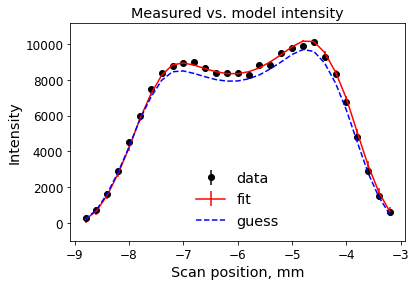

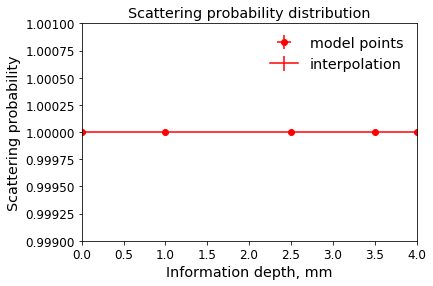

Model saved in ./output/int_SS_hoop_model.dat
Fit saved in ./output/int_SS_hoop_fit.dat
Log saved in ./output/int_SS_hoop.log


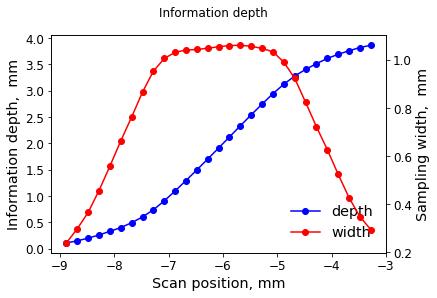

Depth scale saved in ./output/int_SS_hoop_depth.dat


In [10]:
ifit.reportFit(outpath=outpath, file=intfile, plotSampling=True)

## Fit strain distribution
Fitting of strain depth distribution is similar to the above procedure for fitting intensities. The scattering probability distribution determined above will be automatically taken into account in modelling of pseudo-strains below.

### Define initial values

The depth distributions are modelled as a set of points [depth, $\epsilon$(depth)] interpolated by splines of selected order (1 to 3). Define below a minimum number of depth and strain values which gives a satisfactory estimate of the strain distribution. 

In [30]:
# Define strain depth distribution  
# Give initial values, followed by flags (0|1), fx=1 means a free variable, 0 for fixed.  

# initial depth values [mm]
x =  [0., 1., 2.0 , 2.5, 3.0 ,  3.5  , 3.7  ,   4.]
fx = len(x)*[1]
fx[-1] = 0

# initial strain values [1e-6]
y =  len(x)*[0.]
fy = len(y)*[1]
fy[0]=0


# Set the method for interpolation between the nodes.
# Use one of 'natural','clamped', 'PCHIP', 'Akima'
# PCHIP = Piecewise cubic Hermitian interpolation polynomial
interpolation = 'natural' 

# Calculate d0 correction from the bulk strain values?
d0auto = False
if d0auto:
    # Define data range to be used for calculation of eps0:
    n = epsdata.shape[0]  # total number of rows in the input data
    # n1, n2: point index in 0 .. n-1 range
    n1 = int(0.5*n) - 2  # 1st range point 
    n2 = int(0.5*n) + 2  # last range point 
    # python range convention: epsdata.shape[0]-1 is the last row index.
else:
    # give value of eps0 in strain units:
    eps0  = 0.    

# Define a constraint function (optional)
def constraint(params):
    # constraint example: keeps surface strain at 0 with 50ue tolerance
    dist = mc.params2dist(params)
    y=dist[1,1]
    return (y-0.)/50. 
# set True to actually apply the above constraint
use_constraint=False

### Make fit estimate

Run the code below. There is rarely a need to edit anything there, but you can still change some details such as number of sampling events, tolerance, number of iterations, ...


Using surface position: 0.0791109

iter=1, chi2=174.656, reg=174.656
iter=11, chi2=174.656, reg=174.656
iter=12, chi2=174.656, reg=174.656
iter=13, chi2=174.656, reg=174.656
iter=18, chi2=1.65967, reg=2.06515
iter=21, chi2=1.65967, reg=2.06515
iter=22, chi2=1.65967, reg=2.06515
iter=27, chi2=1.65967, reg=2.06515
iter=35, chi2=1.12218, reg=1.46546
iter=36, chi2=1.12218, reg=1.46546
iter=38, chi2=1.12218, reg=1.46546
iter=44, chi2=1.12218, reg=1.46546
iter=50, chi2=0.758491, reg=1.09375
iter=56, chi2=0.758491, reg=1.09375
iter=59, chi2=0.758491, reg=1.09375
iter=62, chi2=0.758491, reg=1.09375
iter=66, chi2=0.723032, reg=1.06373
iter=67, chi2=0.723032, reg=1.06373
iter=69, chi2=0.723032, reg=1.06373
iter=82, chi2=0.712899, reg=1.0531
iter=85, chi2=0.712899, reg=1.0531
iter=88, chi2=0.712899, reg=1.0531
iter=90, chi2=0.712899, reg=1.0531
iter=91, chi2=0.712899, reg=1.0531
iter=97, chi2=0.705402, reg=1.04562
iter=99, chi2=0.705402, reg=1.04562
iter=101, chi2=0.705402, reg=1.04562
iter=103, 

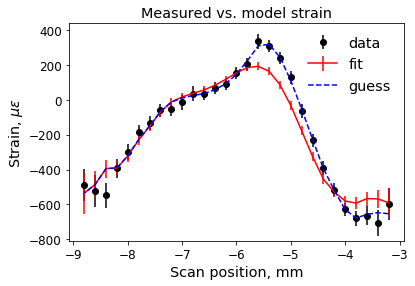

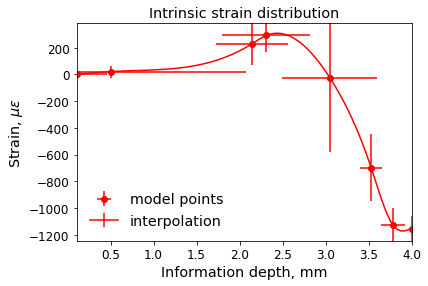

Integral over x in [0, 4]: -339.67 +- 0



In [31]:
# use surface position from intensity fit
zc = ifit.params['xc'].value
print('Using surface position: {:g}\n'.format(zc))

#--------------------------------------------
# Calculate dependences
 
if d0auto:
    # calculate pseudo-strain
    y0 = np.zeros(len(y))
    sfit = mc.Sfit(nev=2000, xdir=sdir, ftol=1.e-3)
    sfit.defDistribution([x, y0*y], [y0*fx, y0*fy], ndim=100)
    tmp = sfit.getSmearedFnc(epsdata[:,0])
    eps1 = np.average(tmp[0][n1:n2+1])
    # get the average measured strain from selected range
    eps2 = np.average(epsdata[n1:n2+1,1])
    # subtract pseudo-strain
    eps0 = eps2 - eps1
    """ NOTE: we must subtract pseudo-strain since it is taken into account 
    by the convolution procedure. eps0 includes only an intrinsic d0 shift
    or an instrumental effect other than the pseudo-strain (e.g. misalignment)
    """
    fmt = 'd0 calculated form points {:d} to {:d}:\neps0 = {:g}'
    print(fmt.format(n1, n2, eps0))
    # exclude n1 .. n2 range from fitting
    tofit = np.concatenate((epsdata[0:n1,:],epsdata[n2:,:]), axis=0)
else:
    tofit = epsdata
    
# Initialize model
sfit = mc.Sfit(nev=3000, xdir=sdir, ftol=1.e-3)

# data to be fitted
sfit.data = tofit

# choose randomly a subset of sampling events
sam.shuffleEvents()

# define strain distribution, dim=number of points for interpolation 
# par = nodes [x,y] values
# vary = corresponding flags for fixed (0) or free(1) variables.
sfit.defDistribution(par=[x, y], vary=[fx, fy], ndim=100, scaled=True)

# define function scaling (amplitude, strain offset, depth-shift) 
sfit.defScaling(par=[1., eps0, zc], vary=[0, 0, 0])

# define interpolation method
sfit.setInterpModel(interpolation)

# define depth range to calculate integrated strain
sfit.avgrange = [0., max(x)]


# set use_constraint=false if you don't want to use the above defined constraint function:
if (use_constraint):
    sfit.constraint = constraint

# Guess fit - the same as for intensity fitting
mc.runFit(sfit, maxiter=300, areg=1e-7, bootstrap=False, loops=False, guess=True)
sfit.reportFit()

## Run fit

Is the above estimate good? Then you can edit the fit parameters below and execute the following box.
It can run a bootstrap cycle to estimate confidence limit. 

It can also scan through the defined range of regularization coefficients (areg) to optimize the smoothing term.

Set runReg=False below if you want to skip this step.

In [32]:
# Use bootstrap method for estimation of confidence limits?
bootstrap = True
# Set loops for the number of bootstrap cycles.
loops = 5
# Run regularization loop?
runReg = False
# Define a list of regularization factors:
areg = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
# Set to True to run strain fit
runSFit = True
# maximum iterations
maxit=300

#------------------------------
# keep following as is
reglog = None
if runSFit and runReg:
    na = len(areg)
    reglog = np.zeros((na,3))
    for ia in range(na):    
        res = mc.runFit(sfit, maxiter=maxit, areg=areg[ia], bootstrap=False, loops=loops)
        reglog[ia] = [areg[ia], sfit.chi, sfit.reg]
        ss = '[areg, chi2, reg] = {:g}\t{:g}\t{:g}\n'.format(*reglog[ia,:])
        print(ss)
        sfx = 'a{:g}_'.format(areg[ia])
        sfit.reportFit(outpath=outpath, file=sfx+epsfile, reglog=reglog) 

In [33]:
# report the table with regularization progress:
if runSFit and runReg:
    ss = 'areg\tchi2\treg\n'
    for ia in range(na):
        ss += '{:g}\t{:g}\t{:g}\n'.format(*reglog[ia,:])
    print(ss)

In [34]:
# choose the best areg value and run fit 
if runSFit:
    areg = 1e-7
    maxit=300
    res = mc.runFit(sfit, maxiter=maxit, areg=areg, bootstrap=bootstrap, loops=loops)

iter=1, chi2=3.57492, reg=3.9156
iter=5, chi2=3.57492, reg=3.9156
iter=6, chi2=3.57492, reg=3.9156
iter=8, chi2=3.57492, reg=3.9156
iter=13, chi2=3.57492, reg=3.9156
iter=18, chi2=1.97576, reg=2.64604
iter=26, chi2=1.97576, reg=2.64604
iter=34, chi2=1.75006, reg=2.40795
iter=35, chi2=1.75006, reg=2.40795
iter=36, chi2=1.75003, reg=2.40792
iter=50, chi2=1.20787, reg=1.8614
iter=51, chi2=1.20787, reg=1.8614
iter=52, chi2=1.20785, reg=1.86138
iter=65, chi2=0.569847, reg=1.22937
iter=66, chi2=0.569847, reg=1.22937
iter=67, chi2=0.569846, reg=1.22937
iter=80, chi2=0.512782, reg=1.15049
iter=83, chi2=0.512782, reg=1.15049
iter=90, chi2=0.512782, reg=1.15049
iter=92, chi2=0.512782, reg=1.15049
iter=93, chi2=0.512782, reg=1.15049
iter=96, chi2=0.500843, reg=1.13881
iter=97, chi2=0.500843, reg=1.13881
iter=99, chi2=0.500843, reg=1.13881
iter=109, chi2=0.500843, reg=1.13881
iter=111, chi2=0.499482, reg=1.13852
iter=114, chi2=0.499482, reg=1.13852
iter=121, chi2=0.499482, reg=1.13852
iter=126, ch

### Plot and save results

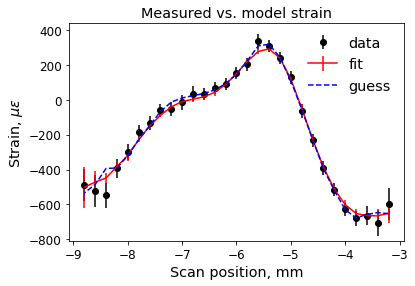

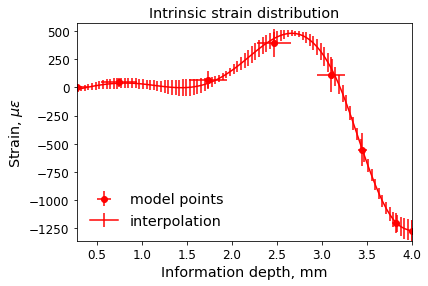

Model saved in ./output/eps_SS_hoop_model.dat
Fit saved in ./output/eps_SS_hoop_fit.dat
Log saved in ./output/eps_SS_hoop.log
Integral over x in [0, 4]: -211.387 +- 66.0031



In [35]:
sfit.reportFit(outpath=outpath, file=epsfile) 